# Telecom Churn Prediction - Starter Notebook

**Author:** Ritesh Lath - Lavakumar Reddy

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [76]:
# Import standard python libraries
import re

In [77]:
# Import the standard python libraries for arrays, plotting, and math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [78]:
# Import the relevant sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [79]:
# Setting some pandas options for dataframe display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [80]:
# Standard functions
def func_data_profiler(in_df):
    """ This function will profile the input dataframe and return the profile report """
    columns = in_df.columns.tolist()
    columns_datatype = in_df.dtypes.tolist()
    columns_null = (in_df.isnull().sum()/in_df.shape[0]*100).values.tolist()
    columns_unique = in_df.nunique().values.tolist()
    profile_df = pd.DataFrame(
                                {
                                    'column': columns, 
                                    'datatype': columns_datatype, 
                                    'null_pc': columns_null, 
                                    'unique': columns_unique
                                },
                                
                            ).sort_values(by='null_pc', ascending=False)
    return profile_df


def func_fillna_with_zero(in_df, columns_list):
    """    This function fills the NaN values in the columns_list with 0    """
    for col in columns_list:
        in_df[col] = in_df[col].fillna(0)
    return in_df

def func_drop_columns(in_df, columns_list):
    """ This function will drop the columns in the columns_list from the input dataframe """
    for col in columns_list:
        in_df = in_df.drop(col, axis=1)
    return in_df

def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array


Load the required datasets for analysis

In [81]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print("Training Data:", data.shape)
print("Test Data:", unseen.shape)
print("Output File:", sample.shape)
print("Data Dictionary:", data_dict.shape)

Training Data: (69999, 172)
Test Data: (30000, 171)
Output File: (30000, 2)
Data Dictionary: (36, 2)


Analyze data to understand the features and its characteristics

In [82]:
data_profile = func_data_profiler(data)
data_profile

,column,datatype,null_pc,unique
143,arpu_3g_6,float64,74.902499,5506
128,count_rech_2g_6,float64,74.902499,30
149,night_pck_user_6,float64,74.902499,2
146,arpu_2g_6,float64,74.902499,5389
119,date_of_last_rech_data_6,object,74.902499,30
122,total_rech_data_6,float64,74.902499,36
134,av_rech_amt_data_6,float64,74.902499,792
125,max_rech_data_6,float64,74.902499,47
131,count_rech_3g_6,float64,74.902499,23
164,fb_user_6,float64,74.902499,2


Remove unwanted columns from the dataset

In [83]:
# Removing columns with high null values (more than 70%)
columns_with_high_null = data_profile[data_profile['null_pc'] > 70].column.tolist()
columns_with_only_one_unique_value = data_profile[data_profile['unique'] == 1].column.tolist()
columns_to_drop = columns_with_high_null + columns_with_only_one_unique_value
data = func_drop_columns(data, columns_to_drop)
unseen = func_drop_columns(unseen, columns_to_drop)

In [84]:
data_profile = func_data_profiler(data)
data_profile

,column,datatype,null_pc,unique
39,std_og_t2f_mou_8,float64,5.290076,1945
30,loc_og_mou_8,float64,5.290076,21950
27,loc_og_t2c_mou_8,float64,5.290076,2204
60,loc_ic_t2m_mou_8,float64,5.290076,19022
51,og_others_8,float64,5.290076,179
24,loc_og_t2f_mou_8,float64,5.290076,3311
63,loc_ic_t2f_mou_8,float64,5.290076,6092
66,loc_ic_mou_8,float64,5.290076,24182
21,loc_og_t2m_mou_8,float64,5.290076,17616
42,std_og_mou_8,float64,5.290076,21745


# 2. Performing EDA 

### 2.1 Understanding 'OG' columns for missing value use cases

In [85]:
list_column_og_6 = []
pattern_column_og_6 = r'.*og.*6'
pattern_column_og_6 = re.compile(pattern_column_og_6)
for col in data.columns:
    if re.search(pattern_column_og_6, col):
        list_column_og_6.append(re.search(pattern_column_og_6, col).string)
data[data['std_og_mou_6'].isnull()][list_column_og_6].isnull().sum()

roam_og_mou_6       2768
loc_og_t2t_mou_6    2768
loc_og_t2m_mou_6    2768
loc_og_t2f_mou_6    2768
loc_og_t2c_mou_6    2768
loc_og_mou_6        2768
std_og_t2t_mou_6    2768
std_og_t2m_mou_6    2768
std_og_t2f_mou_6    2768
std_og_mou_6        2768
isd_og_mou_6        2768
spl_og_mou_6        2768
og_others_6         2768
total_og_mou_6         0
dtype: int64

In [86]:
list_column_og_7 = []
pattern_column_og_7 = r'.*og.*7'
pattern_column_og_7 = re.compile(pattern_column_og_7)
for col in data.columns:
    if re.search(pattern_column_og_7, col):
        list_column_og_7.append(re.search(pattern_column_og_7, col).string)
data[data['std_og_mou_7'].isnull()][list_column_og_7].isnull().sum()

roam_og_mou_7       2687
loc_og_t2t_mou_7    2687
loc_og_t2m_mou_7    2687
loc_og_t2f_mou_7    2687
loc_og_t2c_mou_7    2687
loc_og_mou_7        2687
std_og_t2t_mou_7    2687
std_og_t2m_mou_7    2687
std_og_t2f_mou_7    2687
std_og_mou_7        2687
isd_og_mou_7        2687
spl_og_mou_7        2687
og_others_7         2687
total_og_mou_7         0
dtype: int64

In [87]:
list_column_og_8 = []
pattern_column_og_8 = r'.*og.*8'
pattern_column_og_8 = re.compile(pattern_column_og_8)
for col in data.columns:
    if re.search(pattern_column_og_8, col):
        list_column_og_8.append(re.search(pattern_column_og_8, col).string)
data[data['std_og_mou_8'].isnull()][list_column_og_8].isnull().sum()

roam_og_mou_8       3703
loc_og_t2t_mou_8    3703
loc_og_t2m_mou_8    3703
loc_og_t2f_mou_8    3703
loc_og_t2c_mou_8    3703
loc_og_mou_8        3703
std_og_t2t_mou_8    3703
std_og_t2m_mou_8    3703
std_og_t2f_mou_8    3703
std_og_mou_8        3703
isd_og_mou_8        3703
spl_og_mou_8        3703
og_others_8         3703
total_og_mou_8         0
dtype: int64

### 2.2 Understanding 'IG' columms

In [88]:
list_column_ic_6 = []
pattern_column_ic_6 = r'.*ic.*6'
pattern_column_ic_6 = re.compile(pattern_column_ic_6)
for col in data.columns:
    if re.search(pattern_column_ic_6, col):
        list_column_ic_6.append(re.search(pattern_column_ic_6, col).string)
data[data['std_ic_mou_6'].isnull()][list_column_og_6].isnull().sum()

roam_og_mou_6       2768
loc_og_t2t_mou_6    2768
loc_og_t2m_mou_6    2768
loc_og_t2f_mou_6    2768
loc_og_t2c_mou_6    2768
loc_og_mou_6        2768
std_og_t2t_mou_6    2768
std_og_t2m_mou_6    2768
std_og_t2f_mou_6    2768
std_og_mou_6        2768
isd_og_mou_6        2768
spl_og_mou_6        2768
og_others_6         2768
total_og_mou_6         0
dtype: int64

In [89]:
list_column_ic_7 = []
pattern_column_ic_7 = r'.*ic.*7'
pattern_column_ic_7 = re.compile(pattern_column_ic_7)
for col in data.columns:
    if re.search(pattern_column_ic_7, col):
        list_column_ic_7.append(re.search(pattern_column_ic_7, col).string)
data[data['std_ic_mou_7'].isnull()][list_column_og_7].isnull().sum()

roam_og_mou_7       2687
loc_og_t2t_mou_7    2687
loc_og_t2m_mou_7    2687
loc_og_t2f_mou_7    2687
loc_og_t2c_mou_7    2687
loc_og_mou_7        2687
std_og_t2t_mou_7    2687
std_og_t2m_mou_7    2687
std_og_t2f_mou_7    2687
std_og_mou_7        2687
isd_og_mou_7        2687
spl_og_mou_7        2687
og_others_7         2687
total_og_mou_7         0
dtype: int64

In [90]:
list_column_ic_8 = []
pattern_column_ic_8 = r'.*ic.*8'
pattern_column_ic_8 = re.compile(pattern_column_ic_8)
for col in data.columns:
    if re.search(pattern_column_ic_8, col):
        list_column_ic_8.append(re.search(pattern_column_ic_8, col).string)
data[data['std_ic_mou_8'].isnull()][list_column_og_8].isnull().sum()

roam_og_mou_8       3703
loc_og_t2t_mou_8    3703
loc_og_t2m_mou_8    3703
loc_og_t2f_mou_8    3703
loc_og_t2c_mou_8    3703
loc_og_mou_8        3703
std_og_t2t_mou_8    3703
std_og_t2m_mou_8    3703
std_og_t2f_mou_8    3703
std_og_mou_8        3703
isd_og_mou_8        3703
spl_og_mou_8        3703
og_others_8         3703
total_og_mou_8         0
dtype: int64

### 2.3 Drop Date columns

In [91]:
data = data.drop(labels=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1)
unseen = unseen.drop(labels=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1)

Based on the analysis of the IG, OG and date columns we can safely ignore the attributes carrying null values 

In [92]:
X_scope_features = sorted(data_profile[data_profile['null_pc'] == 0].column.tolist())
y_train = data[X_scope_features].set_index('id').pop('churn_probability')
X_train = data[X_scope_features].set_index('id').drop('churn_probability', axis=1)
X_scope_features.remove('churn_probability')
X_test = unseen[X_scope_features].set_index('id')
X_train_scope_features = X_train.columns.tolist()


### 2.4 Understanding and handling outlier data

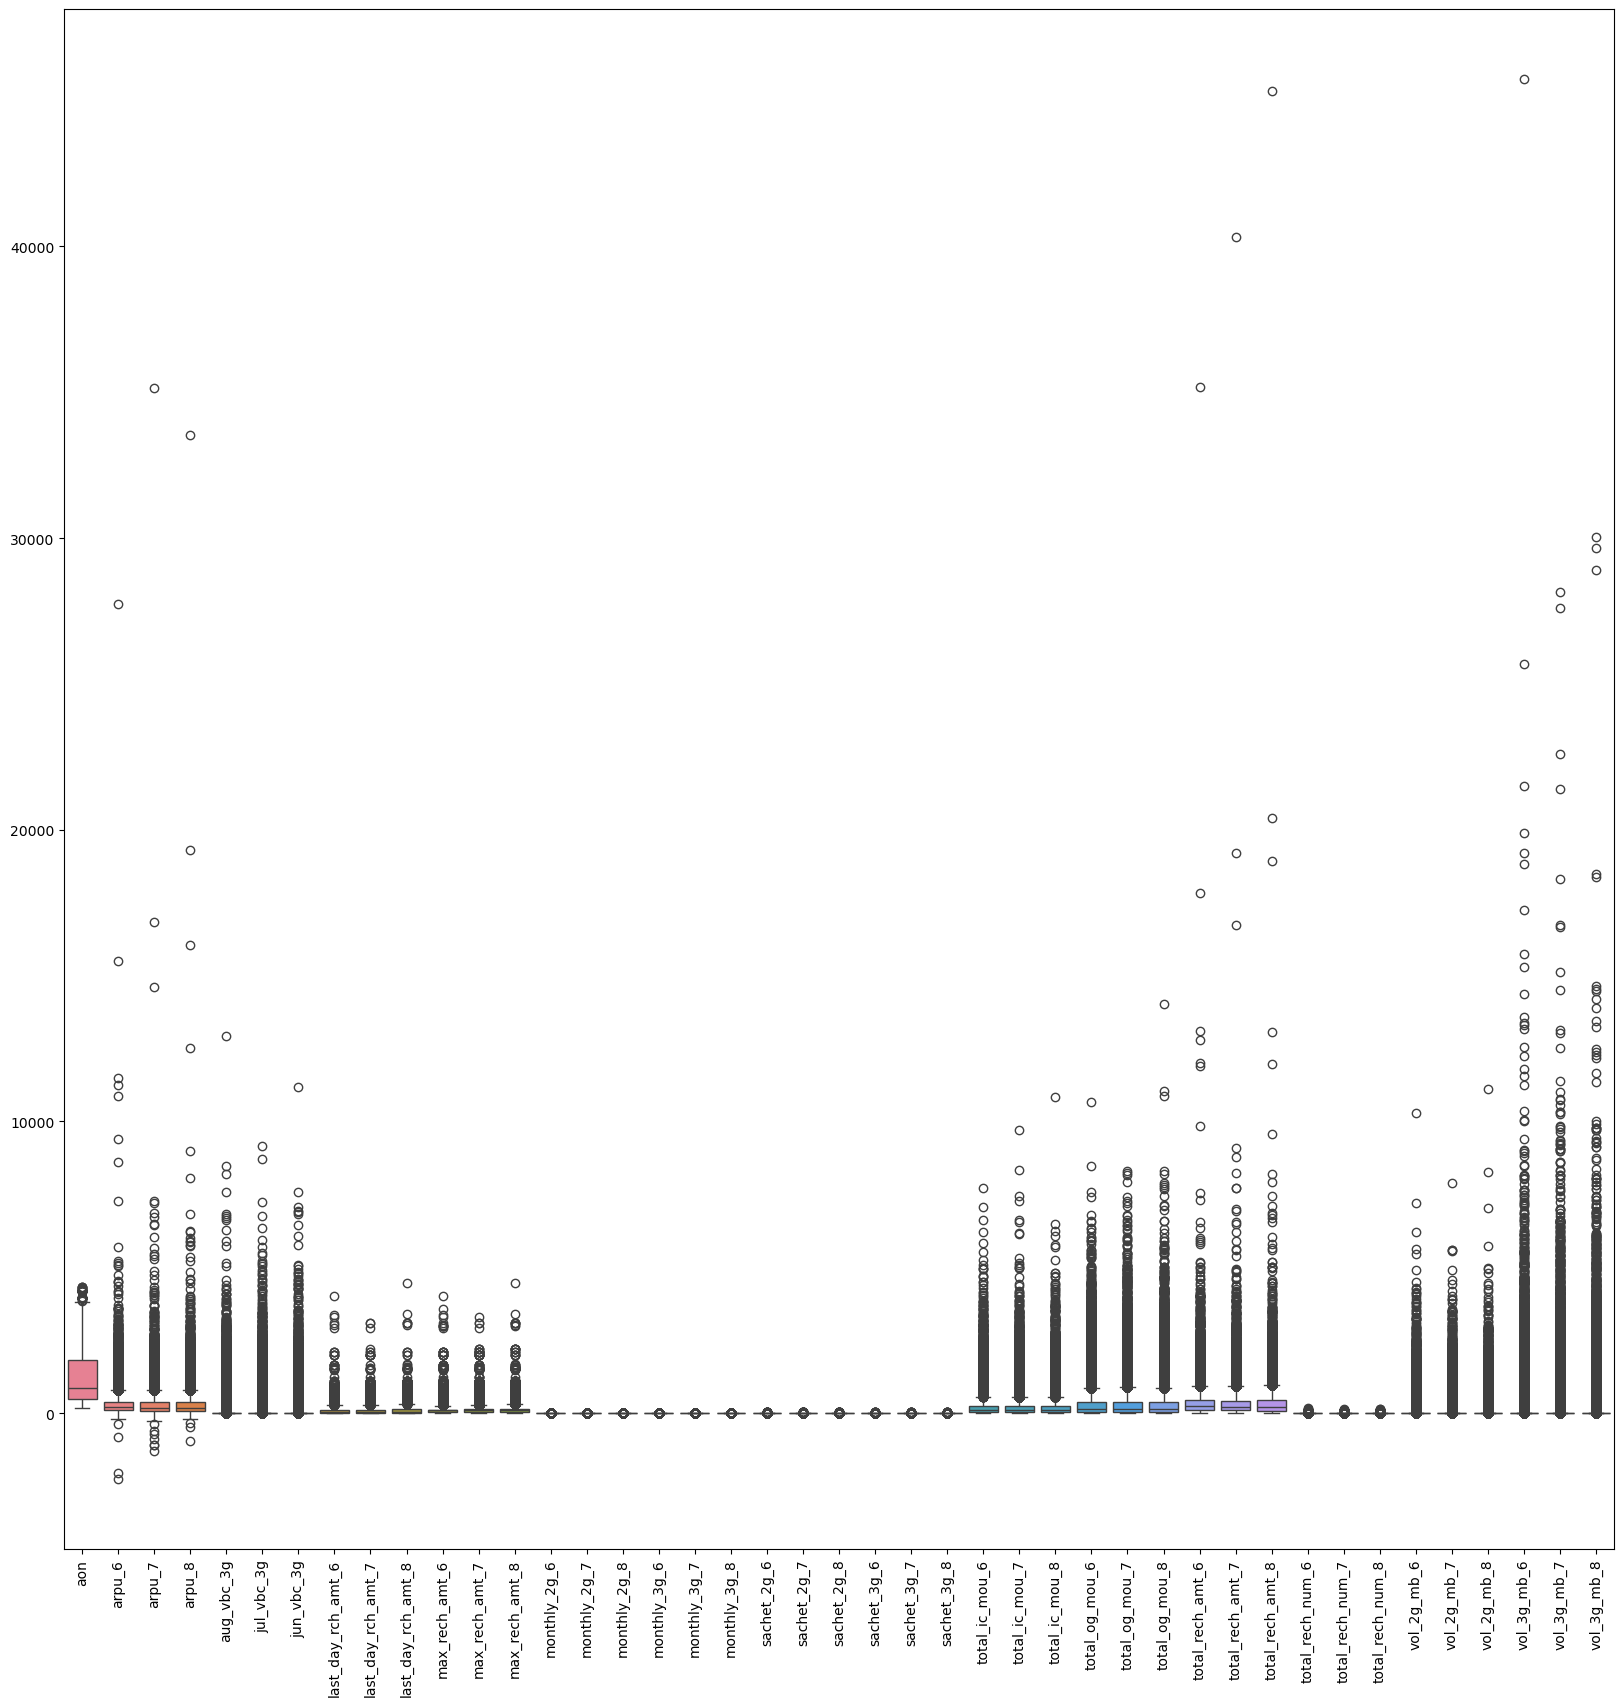

In [93]:
plt.figure(figsize=(20, 20))
plt.xticks(fontsize=10, rotation=90)
sns.boxplot(data=X_train)
plt.show()

### 2.4.1 Understanding monthly 2g & monthly 3g features

Exclude the below columns from the features

In [94]:
X_train[['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,monthly_2g_6,monthly_2g_7,monthly_2g_8
count,69999.000000,69999.000000,69999.000000
mean,0.079287,0.083401,0.080930
std,0.294719,0.304802,0.299254
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,0.000000,0.000000,0.000000
95%,1.000000,1.000000,1.000000
99%,1.000000,1.000000,1.000000


In [95]:
X_train = X_train.drop(labels=['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8'], axis=1)
X_test = X_test.drop(labels=['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8'], axis=1)

Exclude the below columns from the features

In [96]:
X_train[['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,69999.000000,69999.000000,69999.000000
mean,0.075815,0.077730,0.081958
std,0.358905,0.383189,0.381821
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,0.000000,0.000000,0.000000
95%,1.000000,1.000000,1.000000
99%,2.000000,2.000000,2.000000


In [97]:
X_train = X_train.drop(labels=['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8'], axis=1)
X_test = X_test.drop(labels=['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8'], axis=1)

Exclude the below columns from the features

In [98]:
X_train[['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,sachet_2g_6,sachet_2g_7,sachet_2g_8
count,69999.000000,69999.000000,69999.000000
mean,0.388863,0.441406,0.449492
std,1.494206,1.651012,1.632450
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,1.000000,1.000000,1.000000
95%,2.000000,3.000000,3.000000
99%,8.000000,9.000000,8.000000


In [99]:
X_train = X_train.drop(labels=['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8'], axis=1)
X_test = X_test.drop(labels=['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8'], axis=1)

Exclude below columns from features

In [100]:
X_train[['sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,69999.000000,69999.000000,69999.000000
mean,0.075344,0.081444,0.085487
std,0.573003,0.634547,0.680035
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,0.000000,0.000000,0.000000
95%,0.000000,0.000000,0.000000
99%,2.000000,2.000000,2.000000


In [101]:
X_train = X_train.drop(labels=['sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8'], axis=1)
X_test = X_test.drop(labels=['sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8'], axis=1)

In [102]:
X_train[['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8
count,69999.000000,69999.000000,69999.000000
mean,51.773924,51.240204,50.127506
std,212.513909,211.114667,213.101403
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,103.514000,97.410000,93.290000
95%,327.241000,318.672000,302.284000
99%,995.815200,999.260200,986.360000


In [103]:
X_train[['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
count,69999.000000,69999.000000,69999.000000
mean,122.171882,128.934444,135.486541
std,554.869965,554.096072,568.310234
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
90%,302.810000,335.372000,372.540000
95%,831.189000,866.464000,899.073000
99%,2179.583200,2235.606000,2327.368000


### 2.4.2 Understanding VBC

Exclude the columns from the list

In [104]:
X_train[['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g
count,69999.00000,69999.000000,69999.000000
mean,60.07674,65.935830,68.108597
std,257.22681,267.899034,269.328659
min,0.00000,0.000000,0.000000
25%,0.00000,0.000000,0.000000
50%,0.00000,0.000000,0.000000
75%,0.00000,0.000000,0.000000
90%,110.32800,136.272000,160.444000
95%,400.13400,446.353000,464.277000
99%,1188.26780,1254.279000,1226.659800


In [105]:
X_train = X_train.drop(labels=['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis=1)
X_test = X_test.drop(labels=['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis=1)

### 2.4.5 Understanding the below category of attributes
Last Day Recharge Amount <br>
Max Recharge Amount <br>
Total Recharge Frequency <br>

In [106]:
X_train[['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8
count,69999.000000,69999.000000,69999.000000
mean,63.426949,59.294218,62.489478
std,97.954876,95.429492,101.996729
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,30.000000,30.000000,30.000000
75%,110.000000,110.000000,130.000000
90%,128.000000,130.000000,150.000000
95%,200.000000,200.000000,225.000000
99%,400.000000,398.000000,455.000000


In [107]:
X_train[['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,69999.000000,69999.000000,69999.000000
mean,104.569265,104.137573,107.540351
std,121.407701,120.782543,124.396750
min,0.000000,0.000000,0.000000
25%,30.000000,30.000000,30.000000
50%,110.000000,110.000000,98.000000
75%,120.000000,128.000000,144.000000
90%,200.000000,200.000000,225.000000
95%,252.000000,252.000000,252.000000
99%,550.000000,550.000000,550.000000


In [108]:
X_train[['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,total_rech_num_6,total_rech_num_7,total_rech_num_8
count,69999.000000,69999.000000,69999.000000
mean,7.566522,7.706667,7.224932
std,7.041452,7.050614,7.195597
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000
50%,6.000000,6.000000,5.000000
75%,9.000000,10.000000,9.000000
90%,15.000000,15.000000,15.000000
95%,20.000000,21.000000,20.000000
99%,35.000000,35.000000,35.000000


In [109]:
X_final_features = X_train.columns.tolist()
X_final_features

['aon',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8']

# 3. Outlier Handling

In [110]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

X_train = X_train.apply(cap_outliers, axis=0)

C:\Users\lathr\AppData\Local\Temp\ipykernel_13996\3386040379.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4077.918671911545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  array[array>upper_limit] = upper_limit
C:\Users\lathr\AppData\Local\Temp\ipykernel_13996\3386040379.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '357.2915754833435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  array[array>upper_limit] = upper_limit
C:\Users\lathr\AppData\Local\Temp\ipykernel_13996\3386040379.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '345.58269428893806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  array[arr

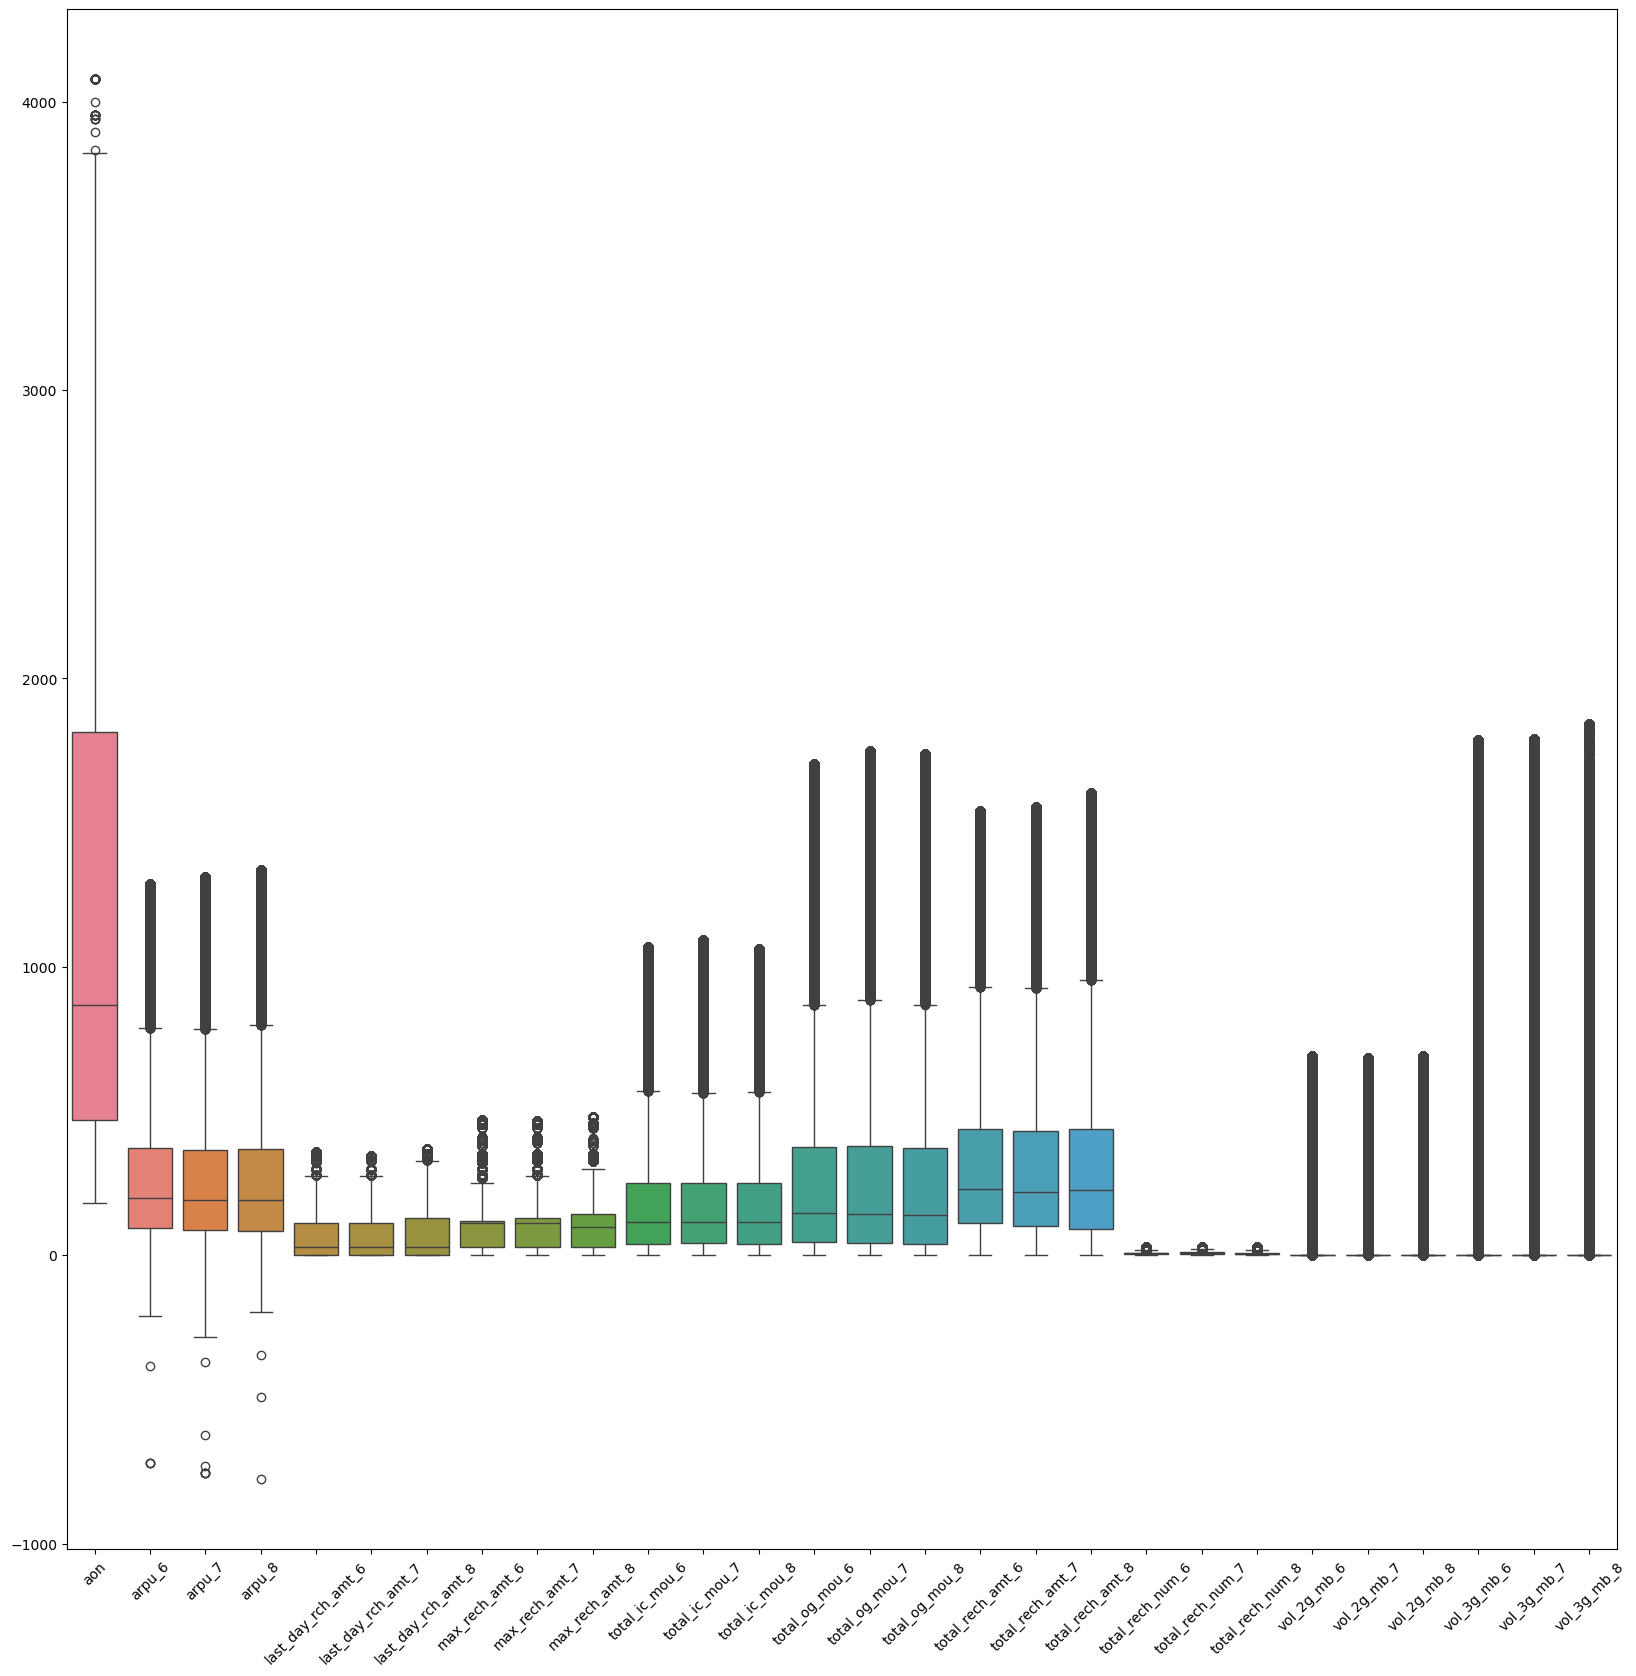

In [111]:
plt.figure(figsize=(20,20))
plt.xticks(fontsize = 10, rotation=45)
sns.boxplot(data = X_train)
plt.show()

# 4. Feature Scaling

Perform Standard Scaling on the features

In [112]:
X_train.columns

Index(['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8'],
      dtype='object')

In [113]:
X_test.columns

Index(['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6',
       'vol_3g_mb_7', 'vol_3g_mb_8'],
      dtype='object')

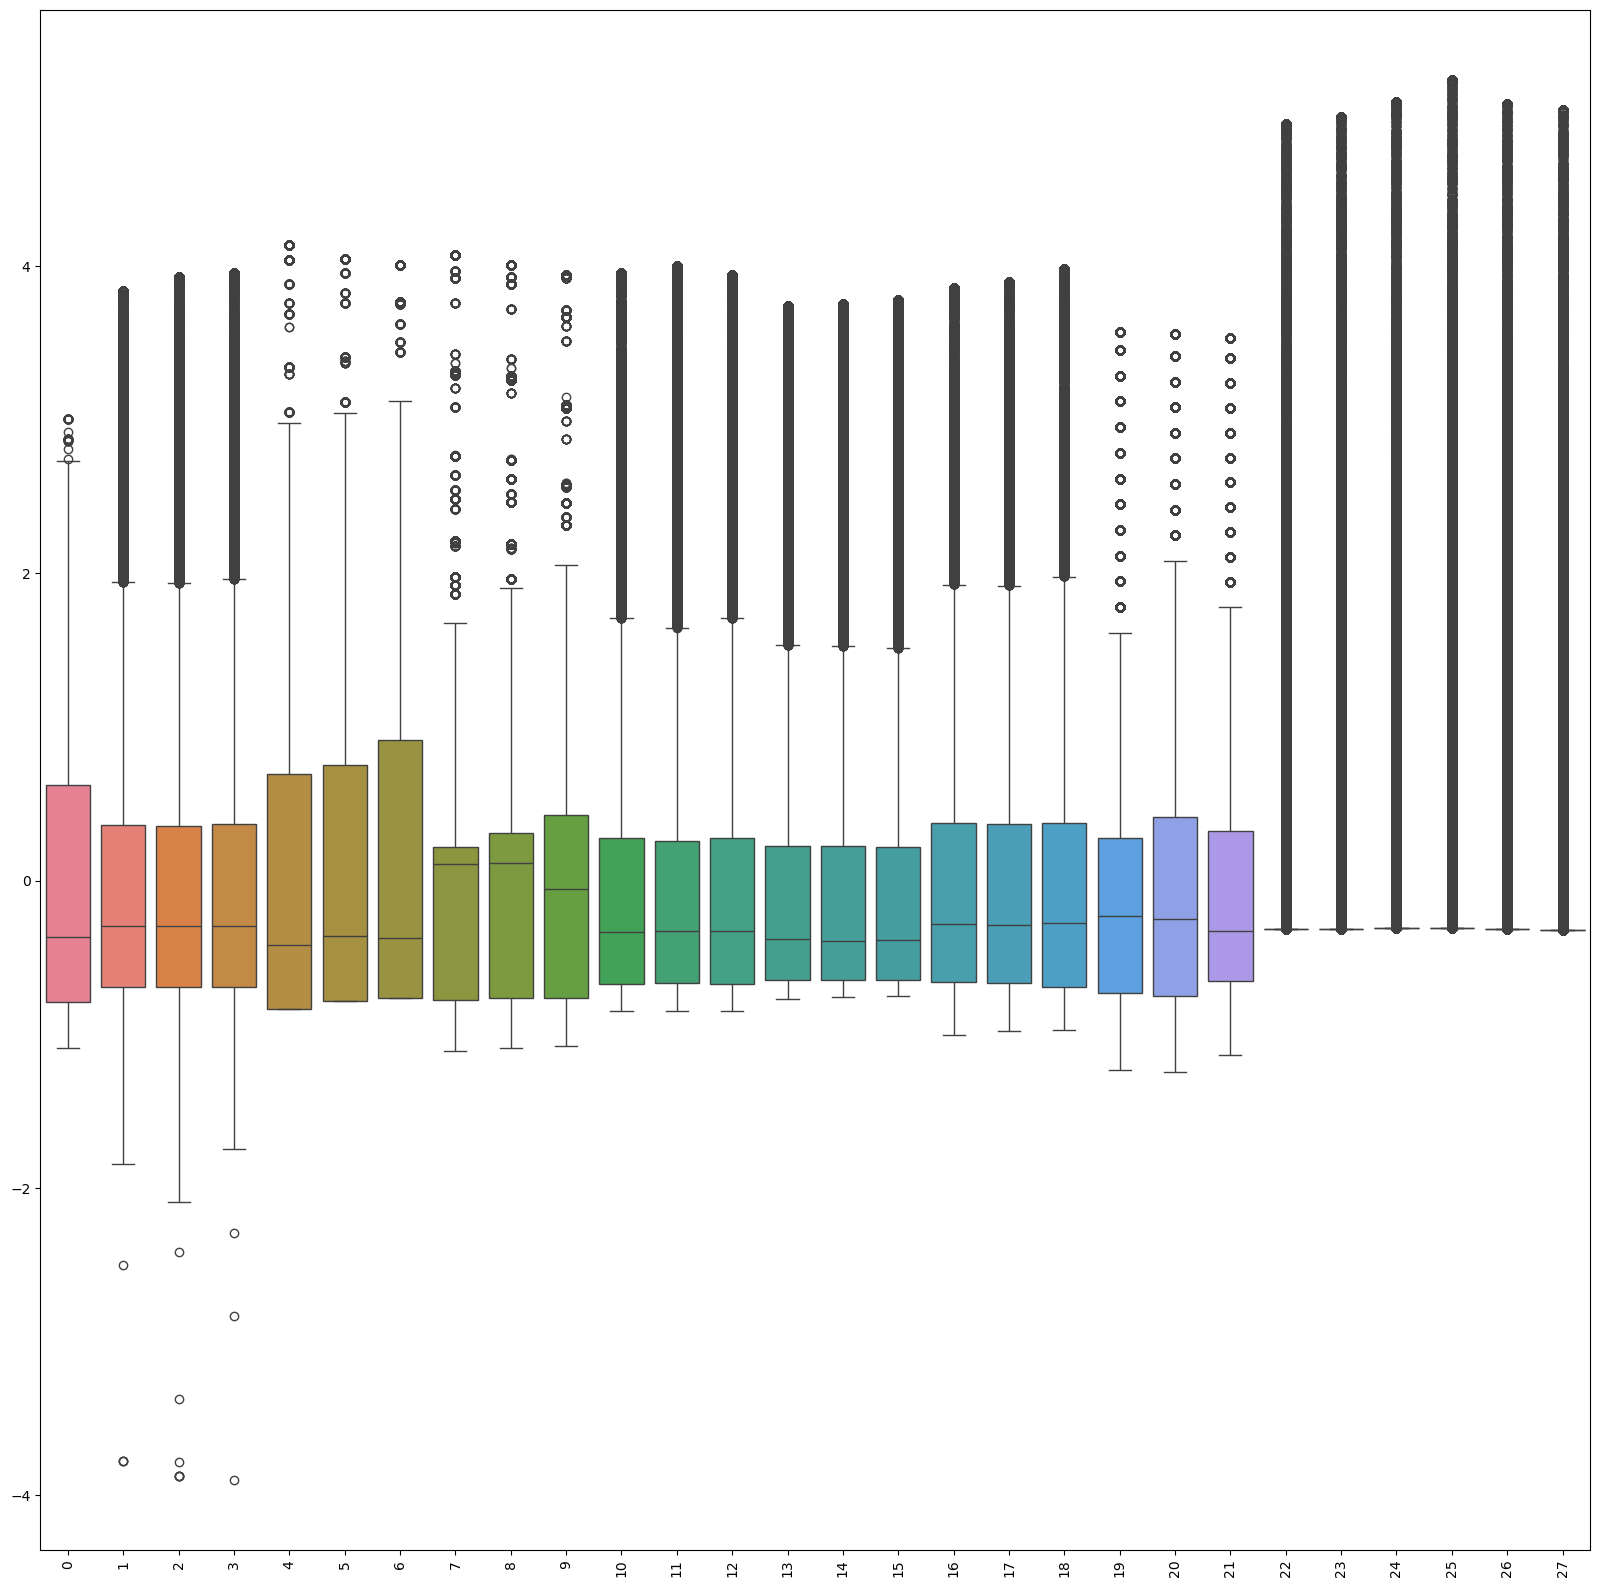

In [114]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)
plt.figure(figsize=(20, 20))
plt.xticks(fontsize=10, rotation=90)
sns.boxplot(data=X_train_scaled)  # This is the scaled data
plt.show()

In [115]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_final_features)
X_train_scaled.describe()
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_final_features)

# 5. Feature Engineering & Model Selection

In [117]:
lr_model = LogisticRegression(random_state=42)
rfe = RFE(estimator=lr_model, n_features_to_select=15)
rfe.fit(X_train_scaled, y_train)


RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=15)

In [118]:
df_X_rfe_selected = pd.DataFrame({'columns': X_final_features, 'selected': rfe.support_, 'ranking': rfe.ranking_})
df_X_rfe_selected.sort_values(by='ranking', ascending=True)

,columns,selected,ranking
0,aon,True,1
24,vol_2g_mb_8,True,1
21,total_rech_num_8,True,1
18,total_rech_amt_8,True,1
16,total_rech_amt_6,True,1
15,total_og_mou_8,True,1
12,total_ic_mou_8,True,1
11,total_ic_mou_7,True,1
9,max_rech_amt_8,True,1
27,vol_3g_mb_8,True,1


In [119]:
df_X_rfe_selected[df_X_rfe_selected['selected']]['columns'].tolist()

['aon',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'last_day_rch_amt_8',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_og_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_8',
 'total_rech_num_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8']

In [121]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled[df_X_rfe_selected[df_X_rfe_selected['selected']]['columns'].tolist()], y_train)
accuracy_score(y_train, lr_model.predict(X_train_scaled[df_X_rfe_selected[df_X_rfe_selected['selected']]['columns'].tolist()]))

0.9137701967170959

# 6. Building Model Using PCA and RandomForest Classifier

In [122]:
pca= PCA(random_state=42)
pca.fit(X_train_scaled)
pca.components_

array([[ 2.99773874e-02,  2.73382611e-01,  2.99197724e-01,
         2.83546648e-01,  1.43386867e-01,  1.60536207e-01,
         1.46538095e-01,  1.80479107e-01,  1.96669593e-01,
         1.92009056e-01,  1.46597730e-01,  1.61144339e-01,
         1.58550121e-01,  2.24902857e-01,  2.47450394e-01,
         2.33014319e-01,  2.71722207e-01,  2.93202628e-01,
         2.76316298e-01,  1.50343608e-01,  1.52238608e-01,
         1.30311658e-01,  4.18772580e-02,  4.37524656e-02,
         4.11402932e-02,  1.02737383e-01,  1.12842912e-01,
         1.10700380e-01],
       [-1.45399651e-01,  4.43452828e-02,  6.42396427e-02,
         4.84866415e-02, -2.39640352e-01, -1.94644262e-01,
        -2.26962274e-01, -2.80376045e-01, -2.56203895e-01,
        -2.60842184e-01, -4.27318300e-02, -3.48368328e-02,
        -3.87853677e-02,  1.73124965e-01,  2.01722401e-01,
         1.86452522e-01,  3.91594783e-02,  6.32280379e-02,
         4.36463988e-02,  2.96069514e-01,  3.39692469e-01,
         3.30459108e-01, -7.21

In [123]:
# Cumuliative varinace of the principal components.
variance_cumu = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
print(variance_cumu)

[ 31.9009  44.4131  53.6107  60.967   67.3974  73.6937  77.5572  80.6536
  83.1407  85.3235  87.2332  88.9392  90.5281  91.8836  92.9999  94.0948
  95.0642  95.9641  96.7807  97.5645  98.1873  98.6576  99.0536  99.378
  99.6093  99.774   99.9043 100.    ]


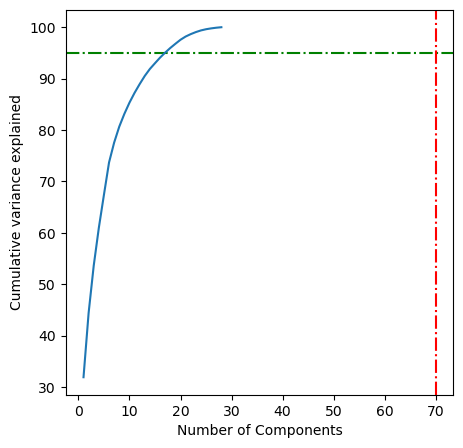

In [124]:
# # Plotting scree plot
fig = plt.figure(figsize=[5,5])
plt.axhline(y=95, color='g', linestyle='-.')
plt.axvline(x=70, color='r', linestyle='-.')
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel("Cumulative variance explained")
plt.show()

As above about 95% of the variance is explained by approximately 18 components

In [125]:
pca_final = IncrementalPCA(n_components=18)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

In [126]:
print("Size of earlier dataset was :",X_train_scaled.shape)
print("Size of dataset after PCA is:", X_train_pca.shape)

Size of earlier dataset was : (69999, 28)
Size of dataset after PCA is: (69999, 18)


In [127]:
print("Size of earlier dataset was :",X_test_scaled.shape)
print("Size of dataset after PCA is:", X_test_pca.shape)

Size of earlier dataset was : (30000, 28)
Size of dataset after PCA is: (30000, 18)


In [132]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_pca, y_train)
accuracy_score(y_train, rfc.predict(X_train_pca))

0.9999857140816297

Hyperparameter Tuning for Random Forest

In [ ]:
# Create the parameter grid based on the results of random search  
param_grid = {
    'max_depth': [5,10],
    'min_samples_leaf': range(100, 200, 400),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200], 
    'max_features': [10,15],
    'oob_score': [True]}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train_pca, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_) 

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0.9142844897784254
{'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200, 'oob_score': True}


In [138]:
rf_final_estimator = grid_search.best_estimator_
print(confusion_matrix(y_train, rf_final_estimator.predict(X_train_pca)))
print(precision_score(y_train, rf_final_estimator.predict(X_train_pca)))
print(accuracy_score(y_train, rf_final_estimator.predict(X_train_pca)))


[[61917   950]
 [ 4668  2464]]
0.7217340363210311
0.9197417105958656


In [143]:
rf_final_estimator.feature_importances_

array([0.27393287, 0.00986586, 0.0264634 , 0.03716021, 0.24883417,
       0.22599199, 0.0607031 , 0.00202967, 0.00495294, 0.00371125,
       0.02667152, 0.02044055, 0.00376652, 0.0079645 , 0.0239487 ,
       0.00856868, 0.00279067, 0.01220338])

# 7. Creating the submission file

In [139]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [144]:
y_test = rf_final_estimator.predict(X_test_pca)
sample['churn_probability'] = y_test

In [146]:
sample['churn_probability'].value_counts()  

churn_probability
0    28518
1     1482
Name: count, dtype: int64

In [147]:
sample.to_csv('kaggle_submission_120320250947.csv', index=False)